You have to split customer ID's to 4 segment:
1. Loyal customers
2. New customers
3. You can't lose them
4. Lost costumers

Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import random 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.cluster import KMeans 
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [305]:
#Reading csv file
df=pd.read_excel("original_data _sifarisler.xlsx")
df.head()

,sifarisci,tarix,Satis (azn)
0,556227575,2019-05-18,15.0
1,557660657,2019-05-18,30.0
2,556724772,2019-05-18,23.0
3,505244006,2019-05-18,28.0
4,546450050,2019-05-18,26.0


### Data Wrangling

In [297]:
df.shape

(1999, 3)

In [300]:
#Checking Missing Values
df.isnull().sum()

sifarisci      9
tarix          0
Satis (azn)    9
dtype: int64

In [299]:
df.dtypes

sifarisci              object
tarix          datetime64[ns]
Satis (azn)           float64
dtype: object

As we can see sifarisci column is object, we need it as int , so let's reformat it

In [306]:
#We will use to_numeric technic as there is some string values in data, which we will convert them to nan
df["sifarisci"]=pd.to_numeric(df["sifarisci"],errors='coerce')

print(df.isnull().sum())
print(df.dtypes)

sifarisci      13
tarix           0
Satis (azn)     9
dtype: int64
sifarisci             float64
tarix          datetime64[ns]
Satis (azn)           float64
dtype: object


So, we have sifarisci as float and our missing values increased due to strings in column

In [307]:
#Cheking duplicates
df.duplicated().sum()

13

In [308]:
# Lets drop them 
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

In [309]:
print(df["sifarisci"].min())
df["sifarisci"].max()

224.0


226502445057.0

Machine Learning models especially K-means clustering can not handle this types of data column as we see that there is huge difference between values, Another point and most important point is that sifarisci column is customer's IDs , which is identical to each customers

In [310]:
#Check duplicates in sifarisci column
df["sifarisci"].duplicated().sum()

434

So we have 447 duplicated customers out of 1999 rows. We can encode them as 1, in others words as loyal customers , and others as 0, which so called not loyal customers. Then we can easily use ID's column in our model

In [311]:
#Encode loyal customers as 1
for i in list(df["sifarisci"][df["sifarisci"].duplicated()].values):
    df["sifarisci"].replace(i,1,inplace=True)
    

In [312]:
#And others as 0
for i in list(df["sifarisci"].values):
    if i>1:
        df["sifarisci"].replace(i,0,inplace=True)
        

In [313]:
df["sifarisci"].unique()


array([0., 1.])

So now we have 2 unique sifarisci values

In [314]:
df["sifarisci"].value_counts()

0.0    1311
1.0     675
Name: sifarisci, dtype: int64

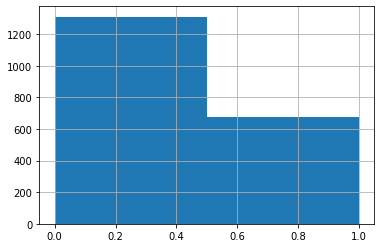

In [334]:
df["sifarisci"].hist(bins=2)

In [315]:
#Let's replace missing Satis values with their mean
df["Satis (azn)"].replace(np.nan,df["Satis (azn)"].mean(),inplace=True)
print(df.isnull().sum())

sifarisci      0
tarix          0
Satis (azn)    0
dtype: int64


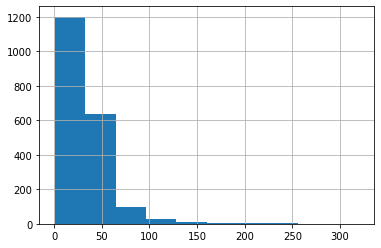

In [341]:
df["Satis (azn)"].hist()

Tarix column is in datetime format which our model can not handle it, so we need to change it.The best way can be seperate each date as year, month and day

In [316]:
df["tarix_year"]=df["tarix"].dt.year
df["tarix_month"]=df["tarix"].dt.month
df["tarix_day"]=df["tarix"].dt.day

In [317]:
df.drop("tarix",axis=1,inplace=True)
df

,sifarisci,Satis (azn),tarix_year,tarix_month,tarix_day
0,0.0,15.0,2019,5,18
1,1.0,30.0,2019,5,18
2,1.0,23.0,2019,5,18
3,0.0,28.0,2019,5,18
4,1.0,26.0,2019,5,18
...,...,...,...,...,...
1994,0.0,30.0,2020,1,16
1995,1.0,55.0,2020,1,16
1996,0.0,25.0,2020,1,16
1997,1.0,80.0,2020,1,16


In [318]:
#We can encode year as 1 or 0
df = pd.get_dummies(df, columns=['tarix_year'], drop_first=True, prefix='year')
df

,sifarisci,Satis (azn),tarix_month,tarix_day,year_2020
0,0.0,15.0,5,18,0
1,1.0,30.0,5,18,0
2,1.0,23.0,5,18,0
3,0.0,28.0,5,18,0
4,1.0,26.0,5,18,0
...,...,...,...,...,...
1994,0.0,30.0,1,16,1
1995,1.0,55.0,1,16,1
1996,0.0,25.0,1,16,1
1997,1.0,80.0,1,16,1


(array([105.,   0.,   0.,   0., 151., 327., 373., 265., 292., 190., 133.,
        150.]),
 array([ 1.        ,  1.91666667,  2.83333333,  3.75      ,  4.66666667,
         5.58333333,  6.5       ,  7.41666667,  8.33333333,  9.25      ,
        10.16666667, 11.08333333, 12.        ]),
 <a list of 12 Patch objects>)

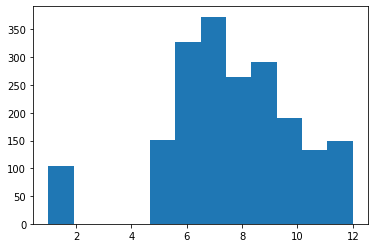

In [333]:
plt.hist(df["tarix_month"],bins=12)


(array([1881.,  105.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

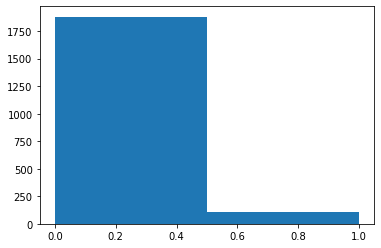

In [330]:
plt.hist(df["year_2020"],bins=2)

We can easily see that most of sales reached to peak in between 6th and 8th months of year 2019

### Feature scaling and Model Building 
For better model performance,Some Clustering models as well as K-Means requires data in a standard form which means we will give 0 mean and 1 variance to data

In [342]:
X = df.values[:]
a = StandardScaler().fit_transform(X)
a

array([[-0.71754731, -0.86452315, -1.07865754,  0.2766949 , -0.23626547],
       [ 1.39363633, -0.25346471, -1.07865754,  0.2766949 , -0.23626547],
       [ 1.39363633, -0.53862532, -1.07865754,  0.2766949 , -0.23626547],
       ...,
       [-0.71754731, -0.45715086, -2.66137928,  0.05313262,  4.23252711],
       [ 1.39363633,  1.78339674, -2.66137928,  0.05313262,  4.23252711],
       [-0.71754731, -0.660837  , -2.66137928,  0.05313262,  4.23252711]])

In [343]:
#K-means model
clusterNum = 4
k_means = KMeans( n_clusters = clusterNum)
k_means.fit(a)
labels = k_means.labels_
print(labels)

[0 2 2 ... 1 1 1]


In [344]:
df["Clusters"]=labels

In [346]:
df["Clusters"].value_counts()

0    1206
2     605
1     105
3      70
Name: Clusters, dtype: int64

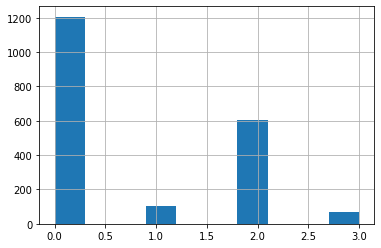

In [359]:
df["Clusters"].hist()

In [360]:
df.loc[df["Clusters"] == 0]

,sifarisci,Satis (azn),tarix_month,tarix_day,year_2020,Clusters
0,0.0,15.0,5,18,0,0
3,0.0,28.0,5,18,0,0
5,0.0,35.0,5,18,0,0
6,0.0,20.0,5,18,0,0
7,0.0,20.0,5,18,0,0
...,...,...,...,...,...,...
1885,0.0,45.0,12,30,0,0
1886,0.0,45.0,12,30,0,0
1887,0.0,45.0,12,30,0,0
1889,0.0,60.0,12,30,0,0


In [361]:
df.loc[df["Clusters"] == 1]

,sifarisci,Satis (azn),tarix_month,tarix_day,year_2020,Clusters
1892,1.0,46.0,1,1,1,1
1893,0.0,30.0,1,1,1,1
1894,1.0,45.0,1,1,1,1
1895,0.0,20.0,1,2,1,1
1896,0.0,70.0,1,2,1,1
...,...,...,...,...,...,...
1994,0.0,30.0,1,16,1,1
1995,1.0,55.0,1,16,1,1
1996,0.0,25.0,1,16,1,1
1997,1.0,80.0,1,16,1,1


In [362]:
df.loc[df["Clusters"] == 2]

,sifarisci,Satis (azn),tarix_month,tarix_day,year_2020,Clusters
1,1.0,30.0,5,18,0,2
2,1.0,23.0,5,18,0,2
4,1.0,26.0,5,18,0,2
10,1.0,26.0,5,17,0,2
13,1.0,25.0,5,17,0,2
...,...,...,...,...,...,...
1879,1.0,50.0,12,29,0,2
1882,1.0,80.0,12,29,0,2
1884,1.0,57.0,12,30,0,2
1888,1.0,25.0,12,30,0,2


In [363]:
df.loc[df["Clusters"] == 3]

,sifarisci,Satis (azn),tarix_month,tarix_day,year_2020,Clusters
12,0.0,288.0,5,17,0,3
41,0.0,150.0,5,21,0,3
61,0.0,155.5,5,22,0,3
80,1.0,100.0,5,24,0,3
229,1.0,88.0,6,7,0,3
...,...,...,...,...,...,...
1794,0.0,90.0,12,10,0,3
1817,1.0,100.0,12,14,0,3
1820,0.0,120.0,12,15,0,3
1876,1.0,90.0,12,28,0,3


In [364]:
df.groupby("Clusters").mean()

,sifarisci,Satis (azn),tarix_month,tarix_day,year_2020
Clusters,,,,,
0,0.000000,32.428102,8.082090,15.677446,0
1,0.333333,34.396817,1.000000,9.742857,1
2,1.000000,33.183177,8.110744,16.226446,0
3,0.500000,130.585714,8.357143,15.500000,0


# We can see from table :
###    - Sifarisci column has 1 mean in cluster 2, which means that all values in that cluster is loyal customers who has regular relations with company
###    - Cluster 3 has the higest mean values for sales, so we can define it as customers who we should not lose them as they contribute more to our company
###    - We can easily define cluster 1 as new customers, all of them is in 2020.
###    - Cluster 0 has the lowest date month value which means that customers in that cluster are not likely in relation with company , so we can define them as lost customers 

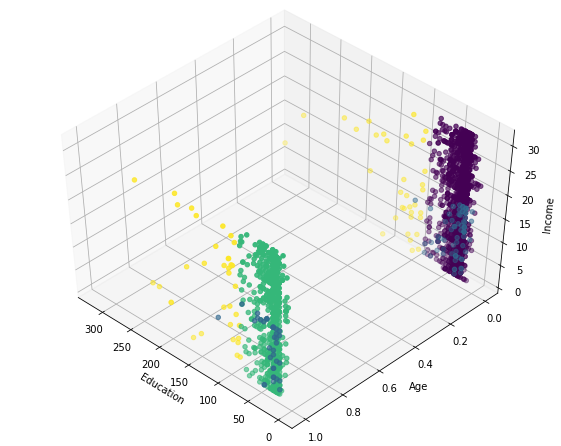

In [358]:
#Visualization of model
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()
# plt.ylabel('Age', fontsize=18)
# plt.xlabel('Income', fontsize=16)
# plt.zlabel('Education', fontsize=16)
ax.set_xlabel('Education')
ax.set_ylabel('Age')
ax.set_zlabel('Income')

ax.scatter(X[:, 1], X[:, 0], X[:, 3],X[:2] ,c= labels.astype(np.float))